<a href="https://colab.research.google.com/github/w4bo/teaching-handsondatapipelines/blob/main/materials/02-MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

Solution of the previous `Hands on`

In [38]:
!pip install paretoset
!pip install flaml[automl]

from paretoset import paretoset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [40]:
def preprocess(normalize=True):
    df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv", delimiter=",")

    num_df = df.drop(columns=["ocean_proximity", "median_house_value"])

    # Filling in (i.e., impute) missing values with the median value
    num_df["total_bedrooms"] = num_df["total_bedrooms"].fillna(num_df["total_bedrooms"].median())

    # Add a new column: population_per_household = population / households
    num_df["population_per_household"] = num_df["population"] / num_df["households"]

    # Add a new column: rooms_per_household = total_rooms / households
    num_df["rooms_per_household"] = num_df["total_rooms"] / num_df["households"]

    # Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
    num_df["bedrooms_per_room"] = num_df["total_bedrooms"] / num_df["total_rooms"]

    if normalize:
        # Apply standardization to all the numeric columns
        num_df = (num_df - num_df.mean()) / num_df.std()

    # One hot encode `ocean_proximity` since it is a categorical attribute
    cat_df = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')

    # Join all the dataframes
    # do not change this line
    return pd.concat([num_df, cat_df, df[["median_house_value"]]], axis=1)


df = preprocess()

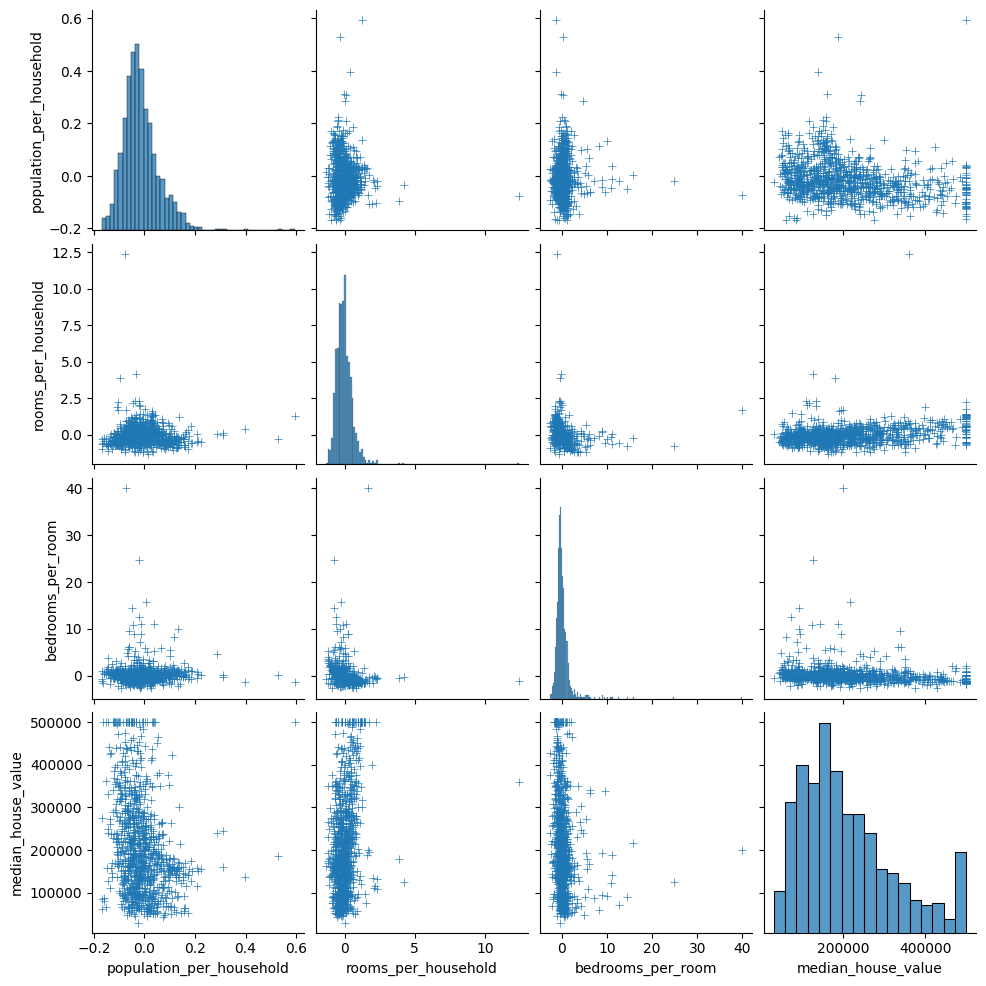

In [41]:
tmp = df[["population_per_household", "rooms_per_household", "bedrooms_per_room", "median_house_value"]]
sns.pairplot(tmp.sample(n=1000, random_state=42), markers='+')
plt.show()

Before delving into machine learning, which are the houses the represent a good tradeof between cost and number of rooms?

<Axes: xlabel='median_house_value', ylabel='total_bedrooms'>

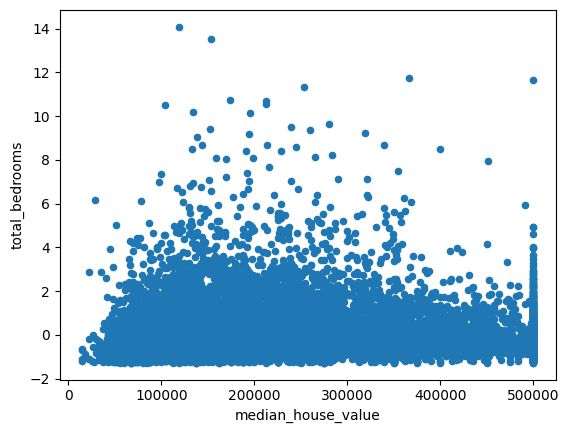

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax)

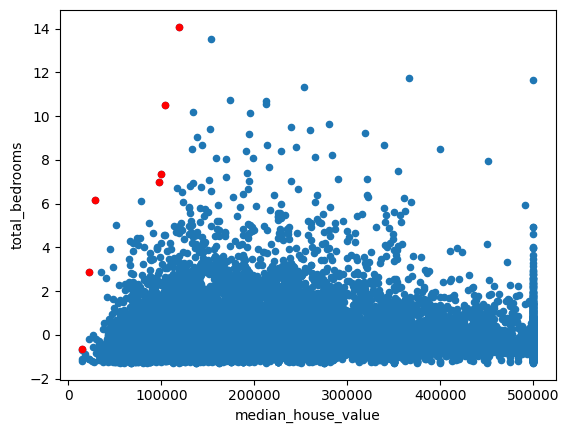

In [5]:
mask = paretoset(df[["median_house_value", "total_bedrooms"]], sense=["min", "max"])
df[mask].plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax, c='red')
fig

<Axes: xlabel='housing_median_age', ylabel='total_bedrooms'>

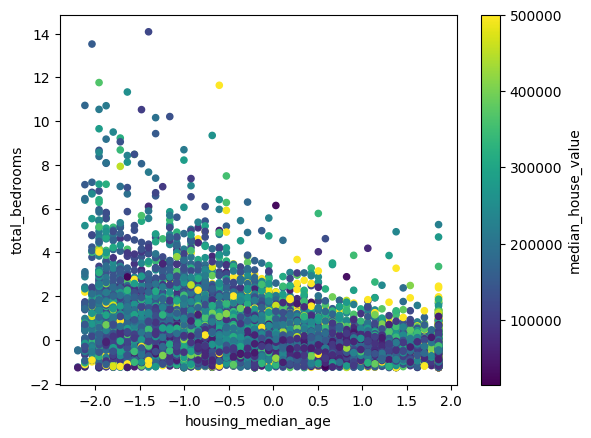

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x="housing_median_age", y="total_bedrooms", c="median_house_value", ax=ax)

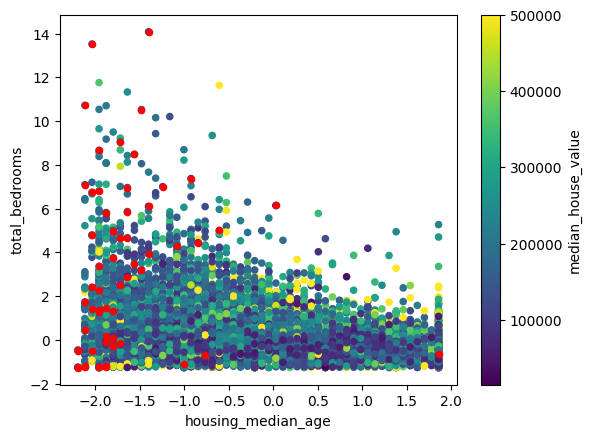

In [7]:
mask = paretoset(df[["housing_median_age", "total_bedrooms", "median_house_value"]], sense=["min", "max", "min"])
df[mask].plot.scatter(x="housing_median_age", y="total_bedrooms", ax=ax, c='red')
fig

Machine Learning is the science (and art) of programming computers so they can learn from data

> Machine Learning is the field of study that gives computers the ability to learn without being explicitly programmed (Arthur Samuel, 1959)

> A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with experience E (Tom Mitchell, 1997)


There are many types of Machine Learning algorithms

Classify them in broad categories, based on the following criteria:

- Whether they are trained with human supervision
    - Supervised, unsupervised, semi-supervised, and reinforcement learning
- Whether they can learn incrementally
    - Online, batch learning
- Whether they compare new to known data points, or detect patterns/models in the training
    - Instance-based, model-based learning


**Sklearn**: Machine Learning in Python
- This library is built upon NumPy, SciPy and Matplotlib
    - Open source and commercially usable
- Covers many algorithms
    - Supervised Learning algorithms: Linear Regression, Support Vector Machine, etc.
    - Unsupervised Learning algorithms: clustering, factor analysis, PCA, neural networks, etc.
    - Cross Validation: check the accuracy of supervised models on unseen data
    - Feature extraction: extract the features from data to define the attributes in image and text data


Check also: 
- https://scikit-learn.org/stable/index.html
- https://scikit-learn.org/stable/modules/tree.html

In [8]:
import sklearn as sk
np.random.seed(42)  # why are we fixing the seed?
print(sk.__version__)

1.4.2


We focus on supervised learning tasks
- The training set you feed to the algorithm includes the desired solutions
- Classification
    - Approximating a mapping function (`f`) from input variables (`X`) to discrete output variables (`y`)
    - The output variables are called labels or categories
    - The mapping function predicts the class or category for a given observation
    - E.g., a spam filter is trained with many example emails along with their class (`spam` or `ham`)
- Regression
    - Approximating a mapping function (`f`) from input variables (`X`) to a continuous output variable (`y`)
    - A continuous output variable is a real-value, such as an integer or floating-point value
    - E.g., predict the price of a car given a set of features (`mileage`, `age`, `brand`, etc.) called predictors


For a supervised learning problem we need:
- Input data along with labels
- Split data between test and training set. How?

Scikit-learn uses data in the form of N-dimensional matrix

- Data as a feature matrix `X` (e.g., a Pandas DataFrame)
    - The samples represent the individual objects described by the dataset (e.g., a `person`)
    - The features describe each sample in a quantitative manner (e.g., `age` and `height`)
- Data as target array `y` (e.g., a Pandas Series)
    - Along with features matrix, we also have the target array (label)


How do we
- distinguish target and feature columns?
- build test and training sets?


In [9]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    # get a list of random numbers
    shuffled_indices = np.random.permutation(len(data))
    # define the size of test dataset
    test_set_size = int(len(data) * test_ratio)
    # the test dataset includes some indexes
    test_indices = shuffled_indices[:test_set_size]
    # the train dataset includes the others (no overlapping)
    train_indices = shuffled_indices[test_set_size:]
    # return the two dataframes
    return data.iloc[train_indices], data.iloc[test_indices]


# get the train and test dataframes
df_train, df_test = split_train_test(df, 0.2)

# get the train feature matrix
X_train = df_train.drop(columns=["median_house_value"]).to_numpy()
# get the test feature matrix
X_test = df_test.drop(columns=["median_house_value"]).to_numpy()
# get the train label array
y_train = df_train["median_house_value"].to_numpy()
y_test = df_test["median_house_value"].to_numpy()  # get the test label array

In [10]:
from sklearn.model_selection import train_test_split
y = df["median_house_value"]  # labels
X = df.drop(columns=["median_house_value"])  # input data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5088,0.643716,-0.773361,-0.765917,-0.803424,-0.533722,-0.617660,-0.582062,-1.521075,-0.043300,-0.905868,2.156065,1,0,0,0,0
17096,-1.327803,0.855889,0.346470,0.003317,-0.173677,-0.362464,-0.189731,0.185559,-0.066782,0.307455,-0.586009,0,0,0,0,1
5617,0.653698,-0.862314,1.061575,-0.675538,-0.650558,-0.336856,-0.676222,-0.169422,0.121441,-0.245505,0.205376,1,0,0,0,0
20060,0.154579,0.111491,-0.368636,-0.479353,-0.350123,0.230050,-0.333586,-1.170516,0.140728,-0.466744,0.482602,0,1,0,0,0
895,-1.193041,0.893343,-1.163197,1.132297,1.597935,1.159000,1.591454,0.063284,-0.057725,-0.331705,0.346285,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.803433,-0.866996,0.505382,-0.598530,-0.800776,-0.677706,-0.738995,1.315560,-0.003697,0.282936,-0.960430,1,0,0,0,0
11964,1.067966,-0.754634,0.346470,0.205461,0.079070,0.289213,-0.132189,-0.431973,0.080259,0.581850,-0.443985,0,1,0,0,0
5390,0.593804,-0.749952,0.584838,-0.245123,0.076685,0.291863,0.071824,-0.492820,0.025170,-0.582935,0.874037,1,0,0,0,0
860,-1.193041,0.912070,-1.083741,0.430524,0.143449,0.310406,0.155521,0.973001,0.010421,0.390575,-0.717278,1,0,0,0,0


In [12]:
y_train

5088     121400.0
17096    363700.0
5617     205600.0
20060     47600.0
895      236000.0
           ...   
11284    229200.0
11964     97800.0
5390     222100.0
860      283500.0
15795    325000.0
Name: median_house_value, Length: 13828, dtype: float64

Estimator

- A consistent interface for a wide range of ML applications
- The algorithm that learns from the data (fitting the data) is an estimator
- It can be used with any of the algorithms like classification, regression, and clustering

All the parameters can be set when creating the estimator

    estimator = Estimator(param1=1, param2=2)
    estimator.param1
All estimator objects expose a fit method that takes a dataset

    estimator.fit(X)
Once data is fitted with an estimator, all the estimated parameters will be the attributes of the estimator object ending by an underscore

    estimator.estimated_param_

Sklearn in action

1. Choose a class of model
    - Import the appropriate Estimator class from Scikit-learn (e.g., a decision tree)
1. Choose model hyperparameters
1. Model Fitting
    - Fit the model by calling `fit()` method of the model instance
1. Applying the model to new data
    - For supervised learning, use `predict()` method to predict the labels for unknown data. 
    - For unsupervised learning, use `predict()` or `transform()` to infer properties of the data.


## Regression

In [13]:
# Choose a class of model, Apply linear regression
# (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
from sklearn.linear_model import LinearRegression  # import the model
# Choose model hyperparameters and initialize the model (i.e., the estimator)
lin_reg = LinearRegression(fit_intercept=True)
# Model fitting
lin_reg.fit(X_train, y_train)  # train it
# "LinearRegression fits a linear model with coefficients w = (w1, ..., wp) to minimize the residual
# sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation."
lin_reg.coef_

array([-56678.25415922, -56570.43784764,  14012.48612813,   6065.60436301,
         7794.76152315, -44411.72364438,  36464.94733357,  78235.6199298 ,
          623.98096453,   7861.81047911,  18857.77231068, -22083.12212996,
       -57203.42335754, 126522.31313893, -28661.2527942 , -18574.51485723])

![image](https://user-images.githubusercontent.com/18005592/232785531-1258fd6b-78a8-4f0a-9bde-bcc7f416f14f.png)

In [14]:
# predict the cost of houses in the test set
housing_predictions = lin_reg.predict(X_test)
housing_predictions

array([ 62413.7678525 , 120560.31036082, 261786.7058476 , ...,
       109483.51261867, 126282.2974808 , 227980.65278688])

This checklist can help you while building your projects

Frame the problem and look at the big picture

- ✔ Define the objective in business terms
- ✖ How should performance be measured? (let's do this!)


We are facing a regression problem

- A typical performance measure for regression problems is the Root Mean Square Error (RMSE)
- RMSE is the standard deviation of the residuals (prediction errors)
- Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are


![image](https://user-images.githubusercontent.com/18005592/232786035-abaca941-12c5-44b0-9085-e9908512803d.png)

70532.34602926501


<Axes: >

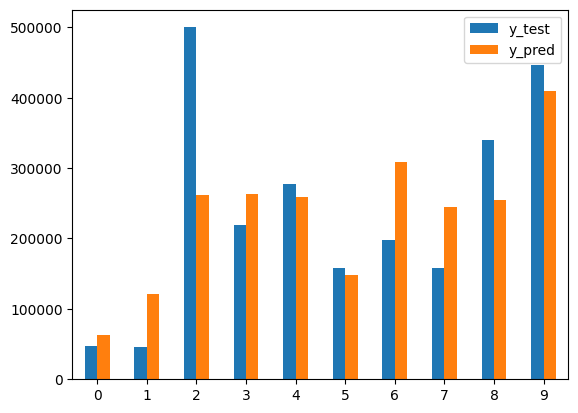

In [15]:
lin_mse = mean_squared_error(y_test, housing_predictions)  # check the error
lin_rmse = np.sqrt(lin_mse)  # apply the squared root of the error
print(lin_rmse)  # print it

# visualize some predictions
df = pd.DataFrame({'y_test': y_test[:10].to_numpy(), 'y_pred': housing_predictions[:10]}, index=[x for x in range(10)])
df.plot.bar(rot=0)


This is better than nothing, but clearly not a great score: most districts’ `median_housing_values` range between 120K USD and  265K USD, so a typical prediction error of ~70K USD is not very satisfying. This is an example of a model underfitting the training
data.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

"A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree."

In [16]:
from sklearn.ensemble import RandomForestRegressor  # import the model


def run_forest(n_estimators, max_features, min_samples_split=5):
    # initialize the model (i.e., the estimator)
    forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    forest_reg.fit(X_train, y_train)  # train it
    # predict the cost of houses in the test set
    housing_predictions = forest_reg.predict(X_test)

    forest_rmse = mean_squared_error(y_test, housing_predictions, squared=True)  # check the error
    forest_rmse = np.sqrt(forest_rmse)  # apply the squared root of the error
    print(forest_rmse)

    df = pd.DataFrame({'y_test': y_test[:10].to_numpy(
    ), 'y_pred': housing_predictions[:10]}, index=[x for x in range(10)])
    df.plot.bar(rot=0)
    return forest_reg

50155.05753085368


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


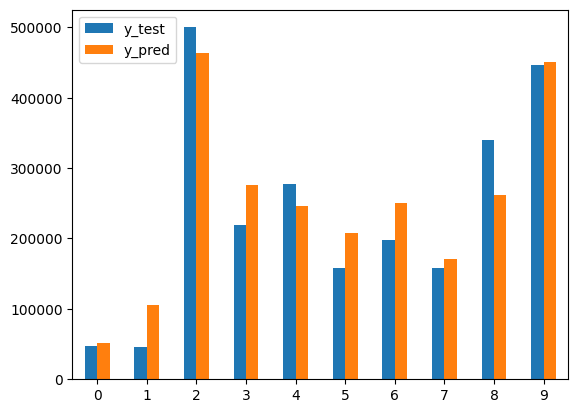

In [17]:
forest_reg = run_forest(100, 1.0)

Look at parameters used by our current forest

In [18]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Hyperparameter tuning

Hyper-parameters: parameters that are not directly learnt within estimators
- In scikit-learn they are passed as arguments to the constructor of the estimator classes
- Any parameter provided when constructing an estimator may be optimized

        estimator.get_params()
A search consists of:
- an estimator
- a parameter space
- a method for searching or sampling candidates
- a cross-validation scheme
- a score function

### Cross validation

![image](https://user-images.githubusercontent.com/18005592/232793622-e98002b4-d58b-465b-8a3d-e7b3d0dafe6f.png)

![Picture1](https://user-images.githubusercontent.com/18005592/232802005-d3a1aff6-23d8-4704-8a3f-a219d2155d30.png)

There are many search algorithms:

- *Random*
    - "The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter."
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- Grid
- AutoML



In [19]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    # Number of trees in random forest
    'n_estimators': [10, 25, 50, 100, 150],
    # Number of features to consider at every split
    'max_features': [1.0, 'sqrt'],
    'min_samples_split': [2, 5]
}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_reg, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_features=1.0, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   0.2s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   0.2s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   0.2s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=25; total time=   1.5s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=25; total time=   1.5s
[CV] END 

{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt'}

49296.853444113134


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForestRegressor(max_features='sqrt', random_state=42)

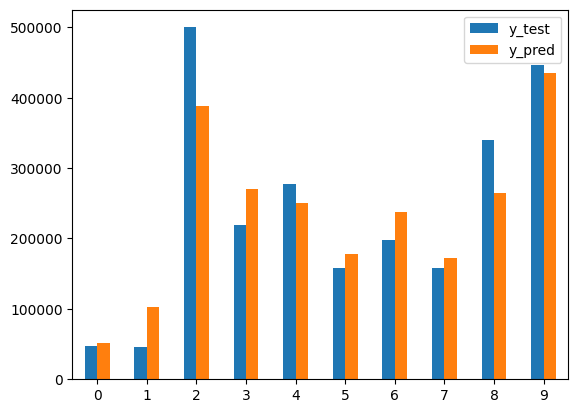

In [20]:
run_forest(n_estimators=100, min_samples_split=5, max_features='sqrt')

#### Dimensionality reduction

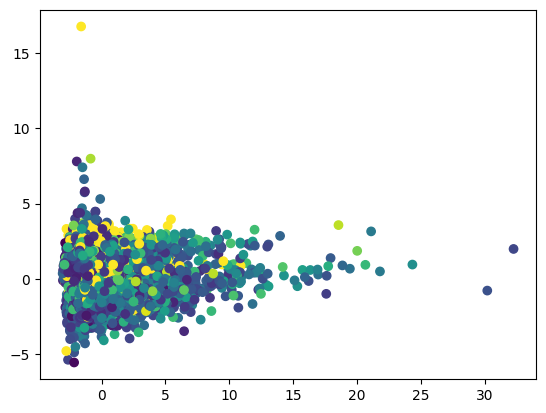

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(X_train.values)

plt.scatter(
    x=result[:, 0],
    y=result[:, 1],
    c=y_train,
    cmap='viridis'
)

In [22]:
# Dump components relations with features
pd.DataFrame(pca.components_, columns=X_train.columns, index=['PC1', 'PC2'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
PC1,0.067570,-0.064488,-0.218377,0.481213,0.491136,0.475472,0.491947,0.045903,-0.004028,0.007194,-0.011824,0.014685,0.001303,-0.000042,-0.013497,-0.002449
PC2,-0.593374,0.610175,-0.081621,0.108533,0.009148,-0.021333,0.004461,0.222566,0.008746,0.284716,-0.304254,-0.140430,0.082383,-0.000152,0.079831,-0.021631


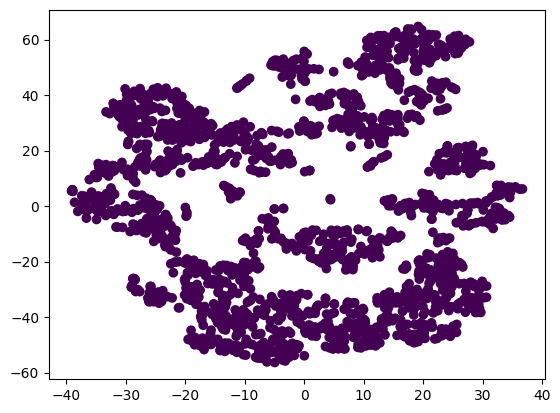

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
result = tsne.fit_transform(X_train.head(2000))

plt.scatter(
    x=result[:, 0],
    y=result[:, 1],
    c=y_train.head(2000).apply(lambda x: 0 if x == 'low' else (1 if x == 'medium' else 2)),
    cmap='viridis'
)

## Classification

Can we turn this into a classification problem?

<Axes: >

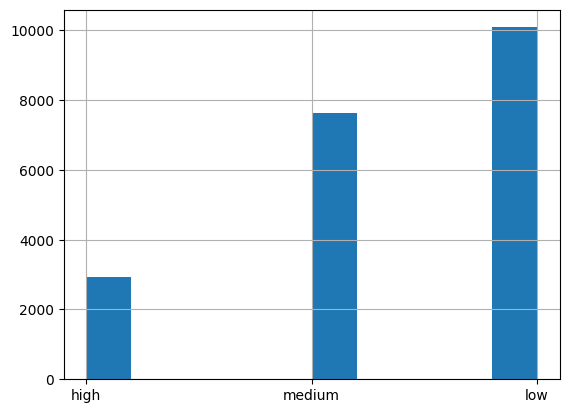

In [24]:
df = preprocess(False)  # clean the dataset withtout standardization
bins = ["low", "medium", "high"]  # the labels we are gonna use
# map bins of values into labels
df["median_house_value"] = pd.cut(df["median_house_value"], 3, labels=bins)
df["median_house_value"].hist()  # plot them


For the sake of performance, we are going to use a manually defined set of features

In [25]:
y = df["median_house_value"]  # labels
# consider only some features from the train dataset
X = df[["latitude", "longitude", "median_income", "population", "households", "total_bedrooms"]]
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Computing performance


![Picture2](https://user-images.githubusercontent.com/18005592/232803278-7a0e5182-4267-410a-a809-7edc54a47980.png)

![Picture3](https://user-images.githubusercontent.com/18005592/232803261-1cae7aac-e3fc-4467-bb45-65455d7a34a7.png)

- Precision: $\frac{tp}{tp + fp}$
- Recall: $\frac{tp}{tp + fn}$
- Accuracy: $\frac{tp + tn}{tp + tn + fp + fpn}$
- F1-score: $2 \cdot \frac{precision \cdot recall}{precision + recall}$

Summing up 
- Accuracy is used when TP and TN are more important while F1-score is used when FN and FP are
- Accuracy can be used when the class distribution is similar, while F1-score is a better when there are imbalanced classes


In [26]:
from sklearn.metrics import accuracy_score
from sklearn import tree
# initialize the model
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=42)
clf = clf.fit(X_train, y_train)  # train it
# predict the cost of houses in the test set
housing_predictions = clf.predict(X_test)
# check the error
accuracy = accuracy_score(y_test, housing_predictions)
accuracy

0.768349970640047

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, housing_predictions, target_names=bins))

              precision    recall  f1-score   support

         low       0.67      0.70      0.68       958
      medium       0.84      0.84      0.84      3303
        high       0.71      0.70      0.70      2551

    accuracy                           0.77      6812
   macro avg       0.74      0.75      0.74      6812
weighted avg       0.77      0.77      0.77      6812



[Text(0.5, 0.9166666666666666, 'median_income <= 4.12\nentropy = 1.435\nsamples = 13828\nvalue = [1970.0, 6786.0, 5072.0]\nclass = medium'),
 Text(0.25, 0.75, 'median_income <= 2.662\nentropy = 1.099\nsamples = 8778\nvalue = [413, 5957, 2408]\nclass = medium'),
 Text(0.125, 0.5833333333333334, 'latitude <= 37.89\nentropy = 0.731\nsamples = 3835\nvalue = [81, 3211, 543]\nclass = medium'),
 Text(0.0625, 0.4166666666666667, 'longitude <= -122.305\nentropy = 0.837\nsamples = 2927\nvalue = [79, 2340, 508]\nclass = medium'),
 Text(0.03125, 0.25, 'latitude <= 37.755\nentropy = 1.263\nsamples = 57\nvalue = [13, 7, 37]\nclass = high'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'longitude <= -117.125\nentropy = 0.796\nsamples = 2870\nvalue = [66, 2333, 471]\nclass = medium'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1875, 0.41666666

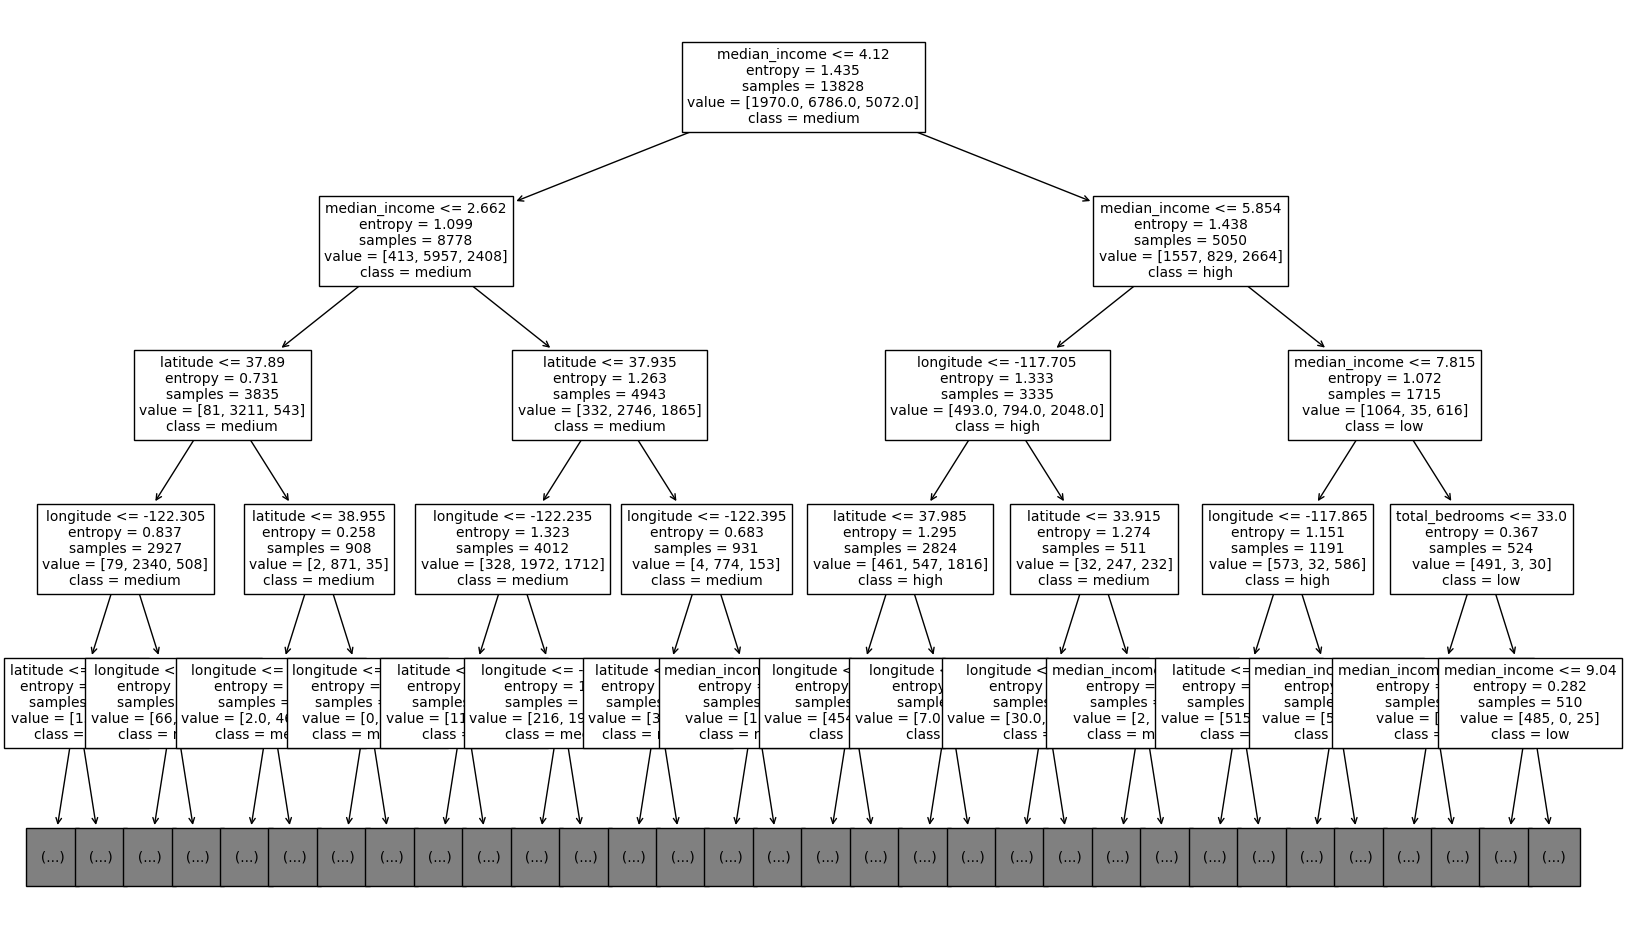

In [28]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=bins, max_depth=4)

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(criterion="entropy", random_state=42) # initialize the model
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.8247210804462712

In [30]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [31]:
random_grid = {'n_estimators': [50, 100, 150], # Number of trees in random forest
               'max_features': [1.0, 'sqrt'], # Number of features to consider at every split
               'min_samples_leaf': [1, 5],
               'max_depth': [2, 5]
              }

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_cls, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.5s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.4s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.5s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_est

{'n_estimators': 100,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 5}

In [32]:
forest_cls = RandomForestClassifier(criterion="gini", random_state=42, n_estimators=50, max_features="sqrt", min_samples_leaf=1, max_depth=5) 
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.7298884321785085

In [33]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## AutoML with auto-sklearn

In [34]:
scale_mapper = {"low": 1, "medium": 2, "high": 3}
y_train = y_train.replace(scale_mapper)
y_test = y_test.replace(scale_mapper)
y_train

5088     1
17096    3
5617     2
20060    1
895      2
        ..
11284    2
11964    1
5390     2
860      2
15795    2
Name: median_house_value, Length: 13828, dtype: category
Categories (3, int64): [1 < 2 < 3]

Check https://microsoft.github.io/FLAML/docs/reference/automl/automl#automl-objects

In [35]:
from flaml import AutoML

automl_settings = {
    "time_budget": 60,  # in seconds
    "metric": "accuracy",
    "task": "classification",
}

automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)

[flaml.automl.logger: 04-10 13:36:41] {1680} INFO - task = classification
[flaml.automl.logger: 04-10 13:36:41] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 04-10 13:36:41] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-10 13:36:41] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 04-10 13:36:41] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-10 13:36:41] {2345} INFO - Estimated sufficient time budget=582s. Estimated necessary time budget=13s.
[flaml.automl.logger: 04-10 13:36:41] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.3435,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 04-10 13:36:41] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-10 13:36:41] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.3435,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 04-10 13:36:4

[flaml.automl.logger: 04-10 13:36:53] {2219} INFO - iteration 34, current learner xgb_limitdepth
[flaml.automl.logger: 04-10 13:36:53] {2392} INFO -  at 12.0s,	estimator xgb_limitdepth's best error=0.2010,	best estimator lgbm's best error=0.1647
[flaml.automl.logger: 04-10 13:36:53] {2219} INFO - iteration 35, current learner extra_tree
[flaml.automl.logger: 04-10 13:36:53] {2392} INFO -  at 12.3s,	estimator extra_tree's best error=0.3687,	best estimator lgbm's best error=0.1647
[flaml.automl.logger: 04-10 13:36:53] {2219} INFO - iteration 36, current learner xgb_limitdepth
[flaml.automl.logger: 04-10 13:36:54] {2392} INFO -  at 12.4s,	estimator xgb_limitdepth's best error=0.1822,	best estimator lgbm's best error=0.1647
[flaml.automl.logger: 04-10 13:36:54] {2219} INFO - iteration 37, current learner xgb_limitdepth
[flaml.automl.logger: 04-10 13:36:54] {2392} INFO -  at 12.6s,	estimator xgb_limitdepth's best error=0.1822,	best estimator lgbm's best error=0.1647
[flaml.automl.logger: 04

[flaml.automl.logger: 04-10 13:37:26] {2219} INFO - iteration 69, current learner rf
[flaml.automl.logger: 04-10 13:37:26] {2392} INFO -  at 45.1s,	estimator rf's best error=0.2155,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:26] {2219} INFO - iteration 70, current learner xgboost
[flaml.automl.logger: 04-10 13:37:27] {2392} INFO -  at 45.3s,	estimator xgboost's best error=0.2108,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:27] {2219} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 04-10 13:37:27] {2392} INFO -  at 45.5s,	estimator xgboost's best error=0.2108,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:27] {2219} INFO - iteration 72, current learner xgboost
[flaml.automl.logger: 04-10 13:37:27] {2392} INFO -  at 45.8s,	estimator xgboost's best error=0.1996,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:27] {2219} INFO - iteration 73, current learner 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-10 13:37:37] {2392} INFO -  at 55.7s,	estimator lrl1's best error=0.4908,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:37] {2219} INFO - iteration 91, current learner lrl1


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-10 13:37:38] {2392} INFO -  at 57.0s,	estimator lrl1's best error=0.4908,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:38] {2219} INFO - iteration 92, current learner xgb_limitdepth


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-10 13:37:39] {2392} INFO -  at 57.6s,	estimator xgb_limitdepth's best error=0.1657,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:39] {2219} INFO - iteration 93, current learner lrl1


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-10 13:37:40] {2392} INFO -  at 58.9s,	estimator lrl1's best error=0.4907,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:40] {2219} INFO - iteration 94, current learner extra_tree


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-10 13:37:40] {2392} INFO -  at 59.2s,	estimator extra_tree's best error=0.2755,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:40] {2219} INFO - iteration 95, current learner extra_tree
[flaml.automl.logger: 04-10 13:37:41] {2392} INFO -  at 59.5s,	estimator extra_tree's best error=0.2755,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:41] {2219} INFO - iteration 96, current learner rf
[flaml.automl.logger: 04-10 13:37:41] {2392} INFO -  at 59.8s,	estimator rf's best error=0.1922,	best estimator lgbm's best error=0.1640
[flaml.automl.logger: 04-10 13:37:42] {2628} INFO - retrain lgbm for 1.0s
[flaml.automl.logger: 04-10 13:37:42] {2631} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7283886529453182,
               learning_rate=0.10158139792925738, max_bin=1023,
               min_child_samples=2, n_estimators=1, n_jobs=-1, num_leaves=126,
               reg_alpha=0.018444261071029835, reg_lambda

In [36]:
# Score the model
prediction = automl.predict(X_test)
prediction

array([1, 1, 3, ..., 1, 1, 3])

In [37]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.7283886529453182,
               learning_rate=0.10158139792925738, max_bin=1023,
               min_child_samples=2, n_estimators=1, n_jobs=-1, num_leaves=126,
               reg_alpha=0.018444261071029835, reg_lambda=0.0076349208100238925,
               verbose=-1)